# Classification - Network Patrol 🕸️🚓

## Inspirations About Imbalanced Classification

[Imbalanced Data Handling](https://github.com/Rhishikesh1997/data-imbalance)

[SMOTE and ADASYN for Imbalanced Classification](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

[Cost-Sensitive Learning for Imabalnced Classification](https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/)

[Imbalanced Multiclass Classification - Glass Indentifiaction](https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/)

[Imbalanced (Binary) Classification - Fraudulent Credit Card Transactions](https://machinelearningmastery.com/imbalanced-classification-with-the-fraudulent-credit-card-transactions-dataset/)

[Imbalanced Multiclass Classification - e-coli Bacteria](https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-e-coli-dataset/)

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from PIL import Image
from matplotlib.cm import viridis

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from utils.modeling import evaluate_models, plot_confusion_matrix
from utils.preprocessing import create_pipeline

In [18]:
# 🖼️ Matplotlib settings

# sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.25,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

In [19]:
# 🥒 Load preprocessed resampled_data from the file:
with open("resampled_data.pkl", "rb") as file:
    resampled_data = pickle.load(file)

In [20]:
data = pd.read_csv("data/Data_set_task_3.csv")

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176640 entries, 0 to 176639
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0.1                176640 non-null  int64  
 1   Unnamed: 0                  176640 non-null  int64  
 2   DST_IP                      176640 non-null  object 
 3   SRC_IP                      176640 non-null  object 
 4   PACKETS                     176640 non-null  int64  
 5   PACKETS_REV                 176640 non-null  int64  
 6   BYTES                       176640 non-null  int64  
 7   BYTES_REV                   176640 non-null  int64  
 8   TIME_FIRST                  176640 non-null  float64
 9   TIME_LAST                   176640 non-null  float64
 10  DST_PORT                    176640 non-null  int64  
 11  SRC_PORT                    176640 non-null  int64  
 12  MEAN                        176640 non-null  int64  
 13  MEDIAN        

There seem to be many columns that should be removed manually (which have more than *50%* of missing data).

In [22]:
data

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,...,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,neris
1,1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,...,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,clear
2,2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,...,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,clear
3,3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,...,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,clear
4,4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,...,-4837.676869,0.187056,0.482592,0.285750,-0.098411,1.314013,2.857491,0.565604,0.021624,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,11618,11618,64.142.97.114.,147.32.84.165,2,0,0,0,1.313558e+09,1.313558e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176636,11619,11619,147.32.84.165.,95.130.170.231,1,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176637,11620,11620,95.130.170.231.,147.32.84.165,2,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176638,11621,11621,147.32.84.165.,199.59.164.114,2,0,0,0,1.313565e+09,1.313565e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear


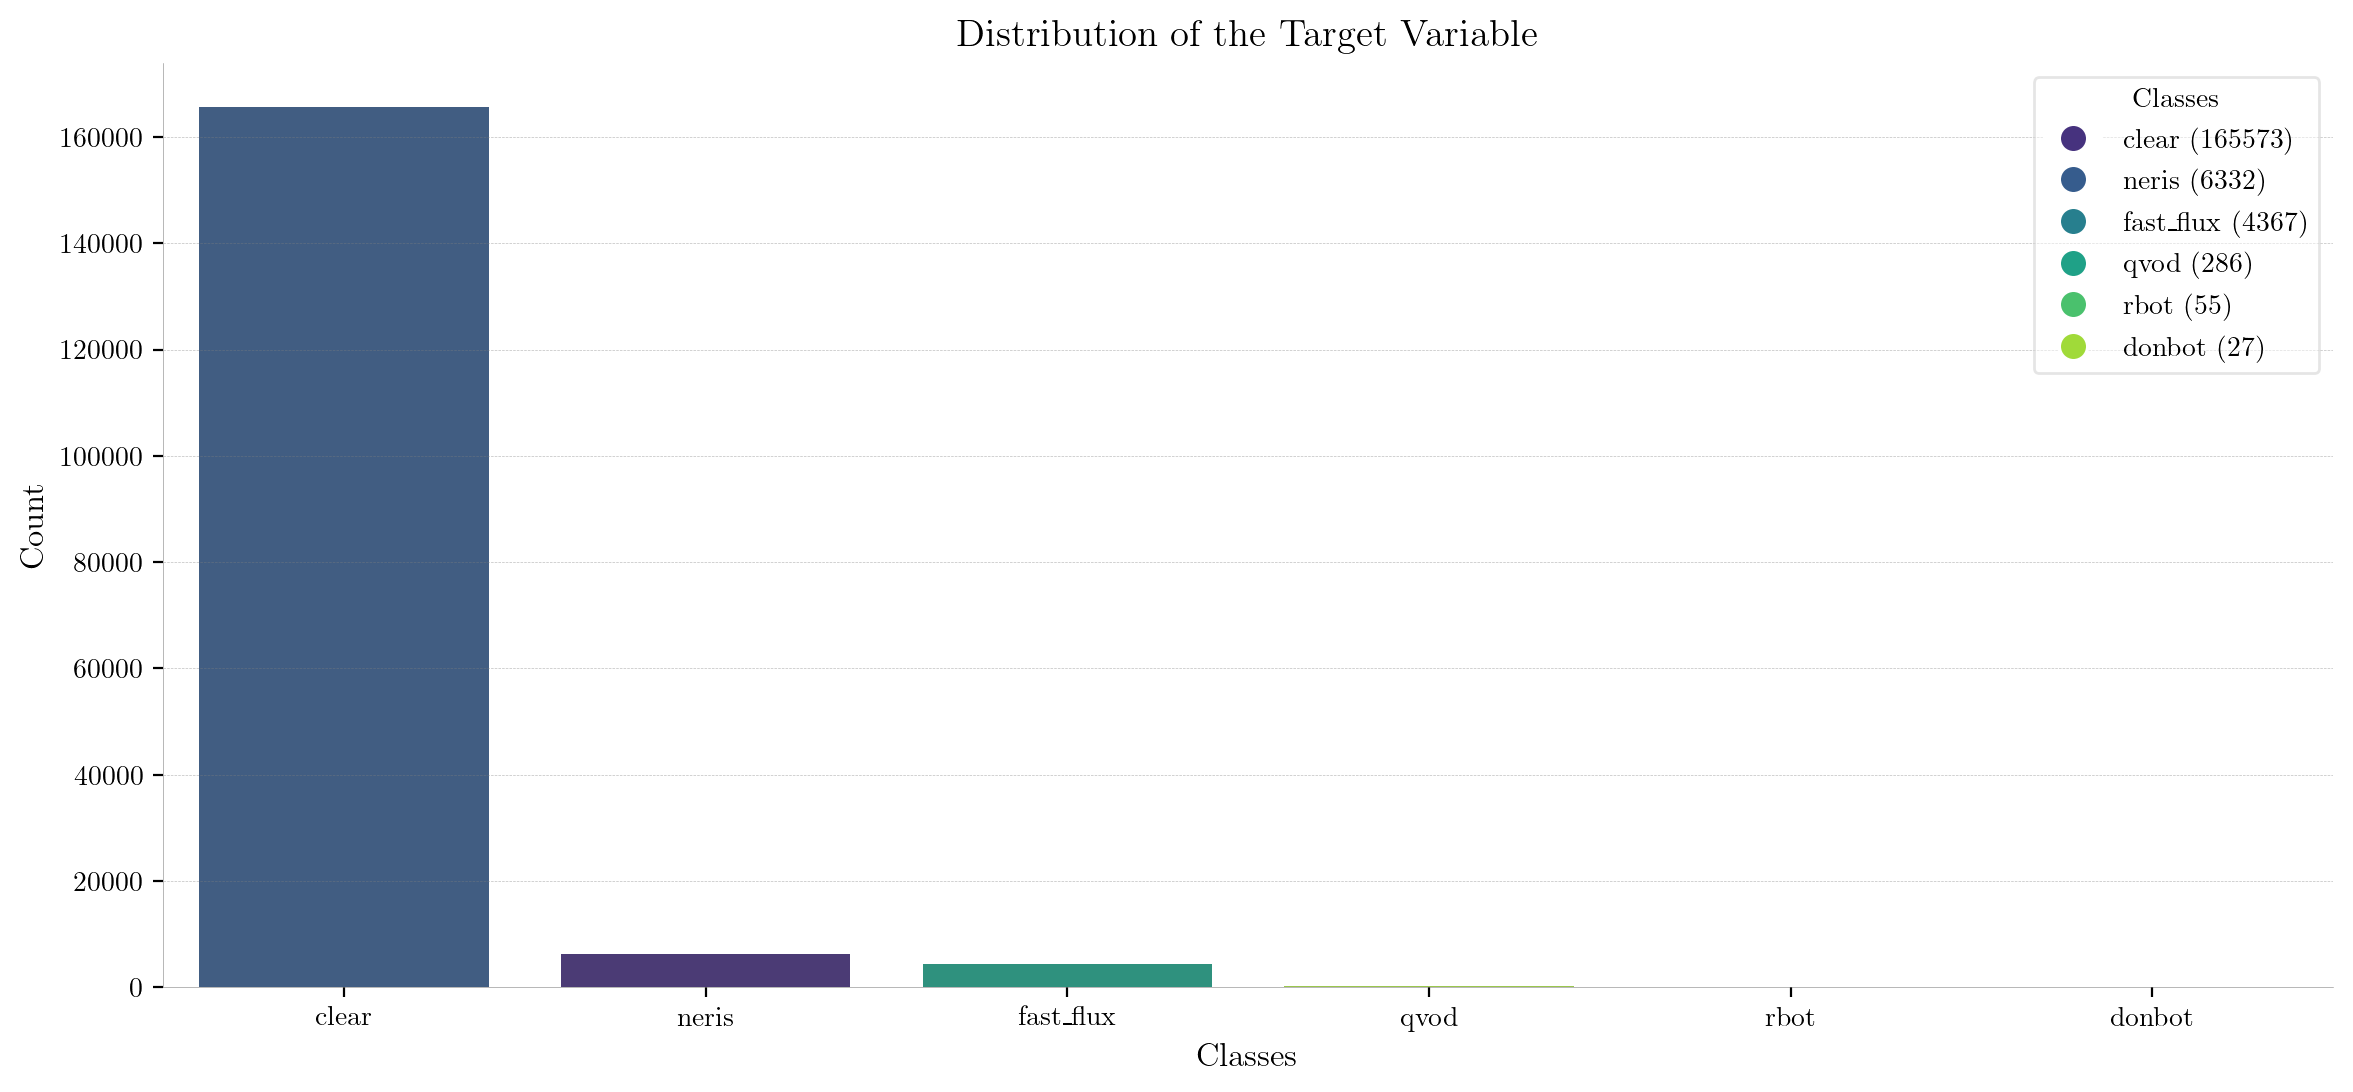

In [23]:
# 📈 Distribution of the target variable
counts = data['LABEL'].value_counts()

plt.figure(figsize=(14, 6))
ax = sns.countplot(x=data['LABEL'], palette='viridis', 
                         order=counts.index, hue=data['LABEL'])

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=sns.color_palette('viridis')[i], markersize=10) for i in range(len(counts))]
labels = [f'{label} ({counts[label]})' for label in counts.index]
ax.legend(handles, labels, title="Classes", loc='upper right', fontsize=10)

plt.title('Distribution of the Target Variable', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


## Preprocessing

1. **Drop Columns**:
   - Removes unnecessary columns that have more than *50%* of missing values. They are specified in the `drop_columns` list.
   
2. **Binary Transformation**:
   - Converts selected columns (e.g., `TRANSIENTS`, `PERIODICITY`) with `True/False` values into binary (*1* for *"True"*, *0* for *"False"*).

3. **Encoding Categorical Variables**:
   - Applies `OrdinalEncoder` to transform categorical columns (`DST_IP` and `SRC_IP`) into numeric values.

4. **Missing Value Imputation**:
   - Fills missing values in the remaining columns using the mean strategy with `SimpleImputer`.

5. **Scaling Features**:
   - Scales the data to a *0-1* range using `MinMaxScaler` to normalize feature values.

6. **Dimensionality Reduction**:
   - Reduces the feature set using PCA while retaining *99%* of the variance.

In [24]:
# Preprocessing
drop_columns = [
    "MIN_POWER", "MAX_POWER", "MIN_POWER_FREQ", "MAX_POWER_FREQ", "POWER_MEAN", "POWER_STD",
    "SPECTRAL_ENTROPY", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS", "SPECTRAL_CENTROID", "SPECTRAL_SPREAD", "SPECTRAL_SLOPE", "Unnamed: 0.1",
    "SPECTRAL_CREST", "SPECTRAL_FLUX", "PERIODICITY_SCDF", "SPECTRAL_ENERGY", "Unnamed: 0"
]

binary_columns = ["TRANSIENTS", "PERIODICITY"]

pipeline = create_pipeline(drop_columns=drop_columns, binary_columns=binary_columns)

X = data.drop(columns=["LABEL"])
y = data["LABEL"]

X_processed = pipeline.fit_transform(X)

oe = OrdinalEncoder()
y_processed = oe.fit_transform(y.values.reshape(-1, 1)) # type: ignore

In [25]:
oe.categories_

[array(['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot'],
       dtype=object)]

In [26]:
class_labels = ['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot']

**PCA** with *99%* explained variance leaves only *20* columns.

#### To resolve class imbalance in our dataset we used the following technique:

**SMOTEENN** (Synthetic Minority Oversampling Technique Edited Nearest Neighbors) is a hybrid sampling method that combines oversampling (**SMOTE**) to address class imbalance by generating synthetic minority samples and undersampling (**ENN**) to remove noisy and ambiguous samples, improving data quality for classification tasks.

As a result, we obtain almost *800 000* records with almost perfectly balanced distribution of target variable.

In [27]:
# 🥷 Create resampled_data ready for cross-validation (training)

 # SMOTEENN setup
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# # Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Dictionary to store resampled data for each fold
resampled_data = {}

for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    #Split data
    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y_processed[train_idx], y_processed[val_idx]
    
#     # Resample and store
X_res, y_res = resample.fit_resample(X_train, y_train)
resampled_data[i] = (X_res, y_res, X_val, y_val)  # Store resampled and validation sets

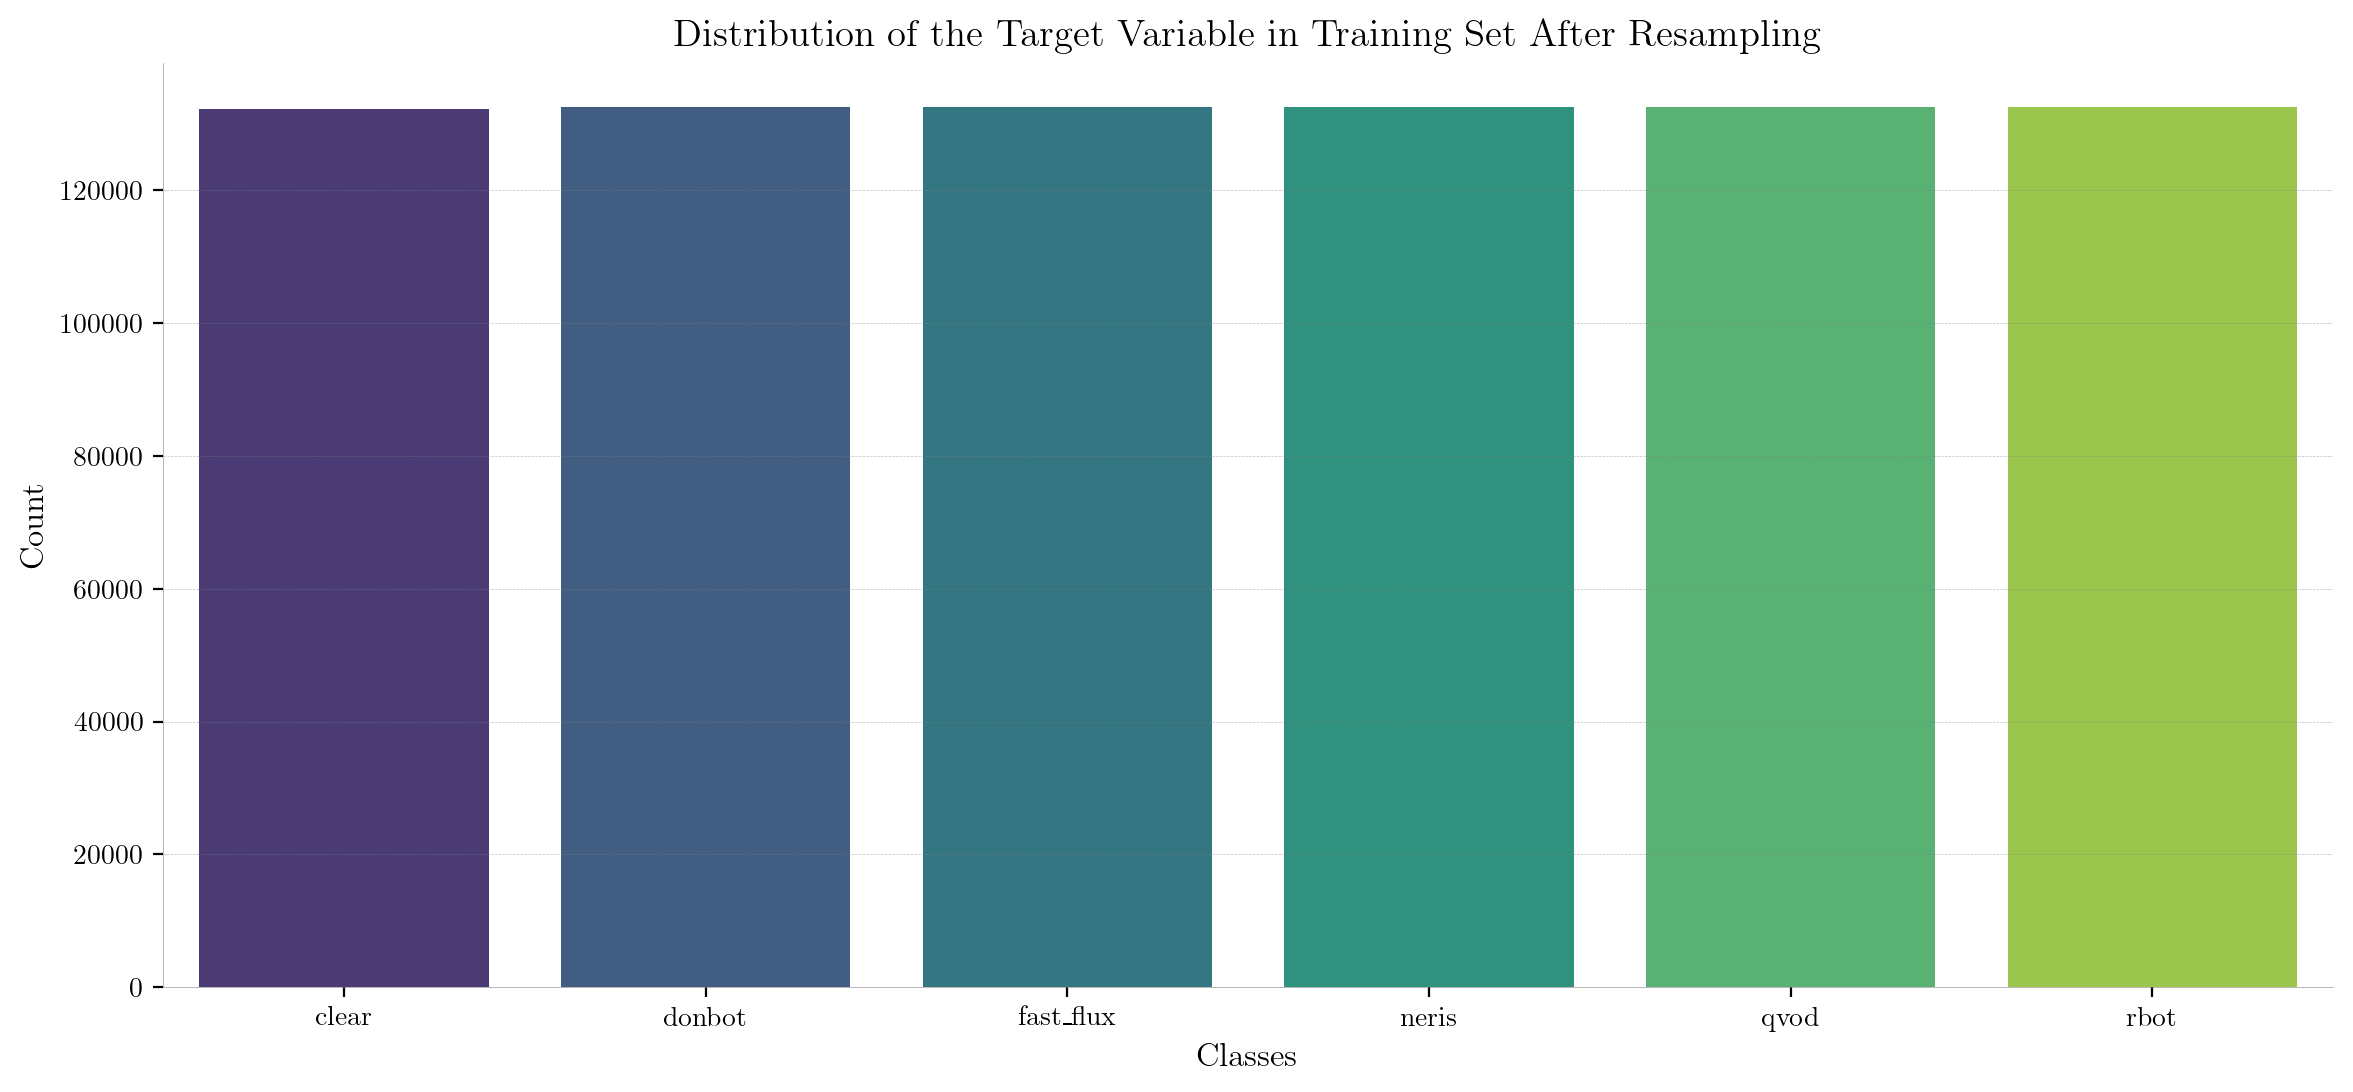

In [28]:
# 📈 Distribution of the Target Variable in Training Set After Resampling
data_array = resampled_data[0][1].flatten()

# Count the occurrences of each index
unique, counts = np.unique(data_array, return_counts=True)
index_counts = dict(zip(unique.astype(int), counts))

# Align the counts with class_labels for the barplot
mapped_counts = [index_counts.get(i, 0) for i in range(len(class_labels))]

plt.figure(figsize=(14, 6))
sns.barplot(x=class_labels, y=mapped_counts, palette='viridis')
plt.title('Distribution of the Target Variable in Training Set After Resampling', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks()
plt.show()

We evaluate models performing 5-fold cross-validation and aggregating the scores for each category using metrics:
- **precision**
- **recall**
- **f1-score**

Additionally, confusion matrix is produced.

---

# Models 🤖

## Logistic Regression 😉

In [ ]:
# 4 min
log_metrics, log_conf_matrices = evaluate_models(resampled_data, [LogisticRegression(max_iter=1000)])


Evaluating model: LogisticRegression


In [34]:
log_metrics = log_metrics['LogisticRegression']
log_metrics

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
LogisticRegression_precision,0.999372,0.146175,0.963864,0.871274,0.467935,0.028319,0.981335
LogisticRegression_recall,0.981030,0.860000,0.990611,0.984839,0.975620,0.854545,0.981335
LogisticRegression_f1-score,0.990116,0.245143,0.977015,0.924564,0.626364,0.054817,0.981335


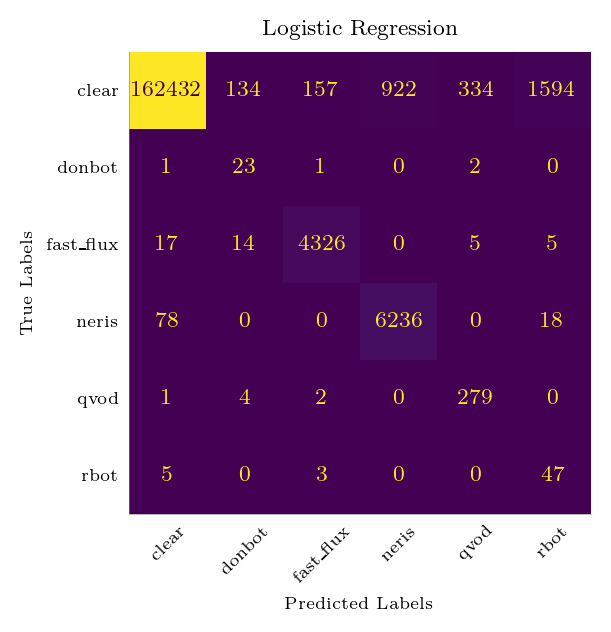

In [35]:
plot_confusion_matrix(log_conf_matrices['LogisticRegression'], class_labels, title="Logistic Regression")

---

## Naive Bayes 👶

In [30]:
# 5 sec
nb_metrics, nb_conf_matrices = evaluate_models(resampled_data, [GaussianNB()])


Evaluating model: GaussianNB


In [31]:
nb_metrics = nb_metrics['GaussianNB']
nb_metrics

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
GaussianNB_precision,0.998192,0.588687,0.946660,0.431848,0.563908,0.003336,0.886809
GaussianNB_recall,0.883622,0.793333,0.920539,0.951360,0.835814,0.690909,0.886809
GaussianNB_f1-score,0.937418,0.653312,0.933377,0.594002,0.663599,0.006640,0.886809


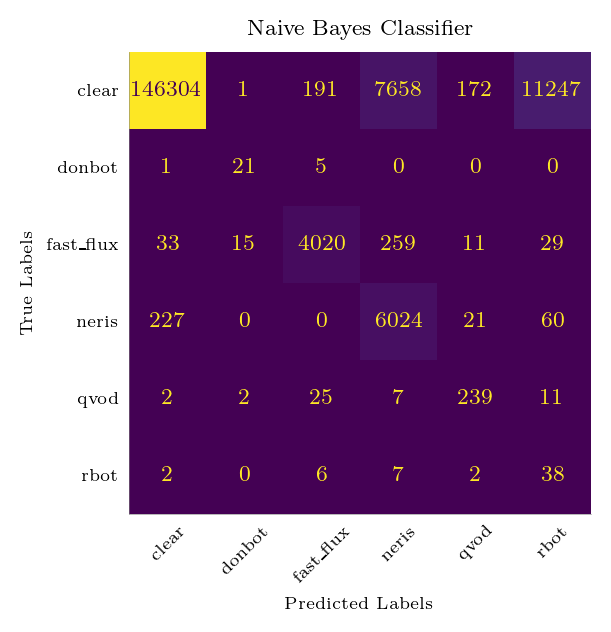

In [32]:
plot_confusion_matrix(nb_conf_matrices['GaussianNB'], class_labels, title="Naive Bayes Classifier")

---

## SVC 🪜

In [42]:
# 45 min
svc_metrics, svc_conf_matrix = evaluate_models(resampled_data, [SVC()])


Evaluating model: SVC


In [43]:
svc_metrics = svc_metrics['SVC']
svc_metrics

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
SVC_precision,0.999715,0.796111,0.996800,0.926663,0.992980,0.530963,0.996496
SVC_recall,0.996642,0.793333,0.996794,0.995420,0.968724,0.909091,0.996496
SVC_f1-score,0.998176,0.753269,0.996794,0.959766,0.980402,0.665219,0.996496


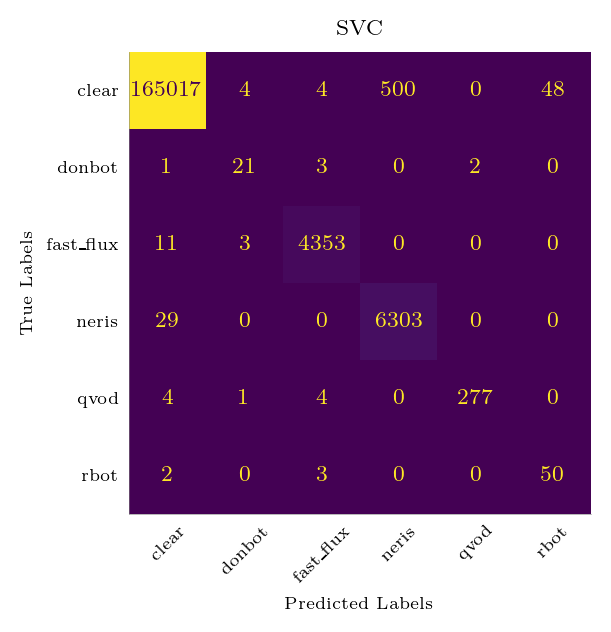

In [44]:
plot_confusion_matrix(svc_conf_matrix['SVC'], class_labels, title="SVC")

---

## Random Forest 🌳

In [45]:
# 45 min
random_forest_metrics, random_forest_conf_matrices = evaluate_models(resampled_data, [RandomForestClassifier()])


Evaluating model: RandomForestClassifier


In [46]:
random_forest_metrics = random_forest_metrics['RandomForestClassifier']
random_forest_metrics

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
RandomForestClassifier_precision,0.999553,0.966667,0.996565,0.983908,0.992590,0.836414,0.998851
RandomForestClassifier_recall,0.999336,0.793333,0.996335,0.993682,0.944223,0.727273,0.998851
RandomForestClassifier_f1-score,0.999444,0.852929,0.996449,0.988764,0.967364,0.775767,0.998851


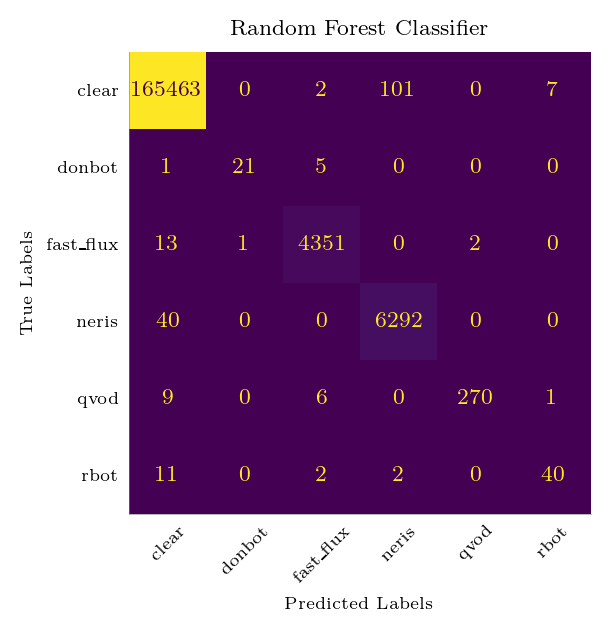

In [47]:
plot_confusion_matrix(random_forest_conf_matrices['RandomForestClassifier'], class_labels, title="Random Forest Classifier")

---

## XGBoost 🔋

In [48]:
# 2 min
xgboost_metrics, xgboost_conf_matrices = evaluate_models(resampled_data, [XGBClassifier()])


Evaluating model: XGBClassifier


In [49]:
xgboost_metrics = xgboost_metrics['XGBClassifier']
xgboost_metrics

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
XGBClassifier_precision,0.999758,0.811667,0.996116,0.983657,0.985902,0.717483,0.998913
XGBClassifier_recall,0.999215,0.793333,0.997023,0.996525,0.958076,0.836364,0.998913
XGBClassifier_f1-score,0.999486,0.782533,0.996566,0.990042,0.971612,0.767484,0.998913


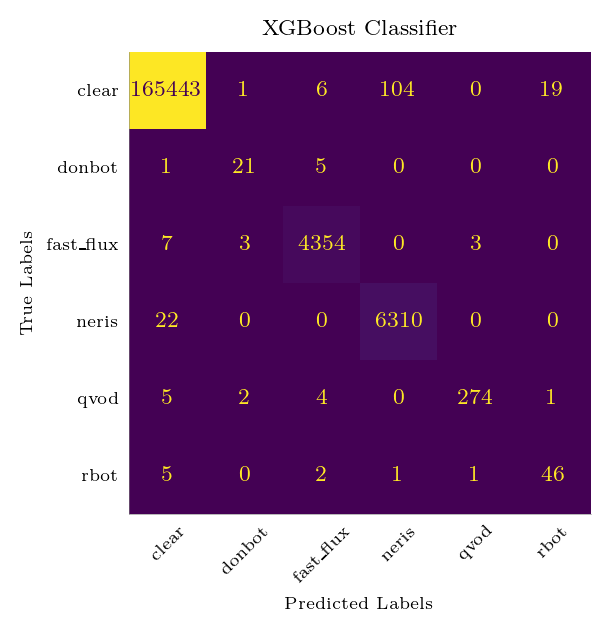

In [50]:
plot_confusion_matrix(xgboost_conf_matrices['XGBClassifier'], class_labels, title="XGBoost Classifier")

---

## MLP Classifier 🧠

In [ ]:
# 20 min
mlp_metrics, mlp_conf_matrices = evaluate_models(resampled_data, [MLPClassifier()])


Evaluating model: MLPClassifier


In [52]:
mlp_metrics = mlp_metrics['MLPClassifier']
mlp_metrics

,clear,donbot,fast_flux,neris,qvod,rbot,Overall Accuracy
MLPClassifier_precision,0.999692,0.813968,0.995666,0.978901,0.963167,0.636404,0.998562
MLPClassifier_recall,0.998865,0.793333,0.997023,0.995104,0.972111,0.854545,0.998562
MLPClassifier_f1-score,0.999278,0.766089,0.996339,0.986928,0.967209,0.722721,0.998562


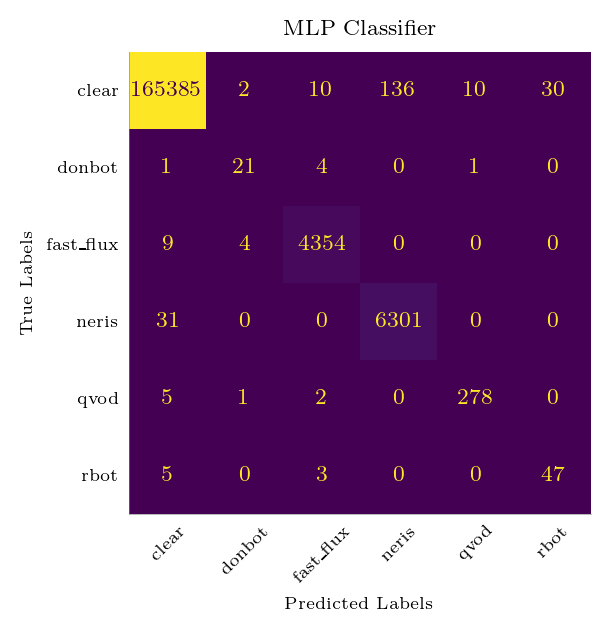

In [53]:
plot_confusion_matrix(mlp_conf_matrices['MLPClassifier'], class_labels, title="MLP Classifier")

---

# Models Comparison 📋

In [79]:
# 📊 Compare the models by averaged f1-score over all classes
all_models = pd.concat([xgboost_metrics, random_forest_metrics, svc_metrics, log_metrics, nb_metrics, mlp_metrics])
all_models['Final Score'] = all_models[class_labels].mean(axis=1)
all_models.sort_values(by='Final Score', ascending=False)
all_models = all_models[all_models.index.str.contains('f1')].sort_values(by='Final Score', ascending=False)
all_models = all_models[['Final Score']]
all_models

,Final Score
RandomForestClassifier_f1-score,0.930119
XGBClassifier_f1-score,0.917954
MLPClassifier_f1-score,0.906427
SVC_f1-score,0.892271
LogisticRegression_f1-score,0.636336
GaussianNB_f1-score,0.631391


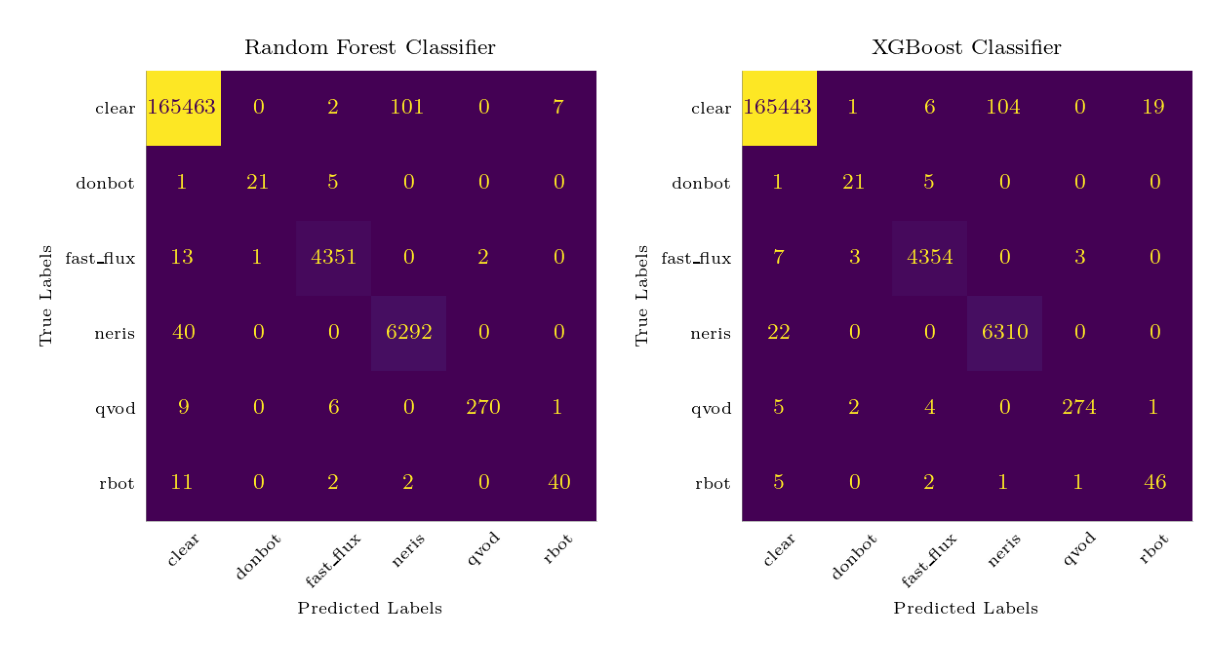

In [ ]:
# 📫 Comparison of two best-performing models

# Load the two PNG images
image1 = Image.open("confusion_matrices/random_forest.png")
image2 = Image.open("confusion_matrices/xg_boost.png")

# Ensure both images are the same size
image1 = image1.resize((611, 632))
image2 = image2.resize((611, 632))

# Combine the images side by side
total_width = image1.width + image2.width
total_height = max(image1.height, image2.height)
combined_image = Image.new("RGB", (total_width, total_height))

# Paste the images into the combined canvas
combined_image.paste(image1, (0, 0))
combined_image.paste(image2, (image1.width, 0))

# Display the combined image
plt.figure(figsize=(16, 4))  # Adjust figure size as needed
plt.imshow(combined_image)
plt.axis("off")  # Turn off the axis
plt.show()


## XGBoost 🔋
### Advantages ✅:
1. more accurate for all *"not clear"* classes
2. less predicted as clear but actually dangerous
3. the runtime is approx 25 times faster than for Random Forest

### Disadvantages ❎:
1. less correctly identified as clear (very insignificant)
2. more examples classified as dangerous even though they were actually safe

# Hyperparameters Tuning 🎶

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 1.5, 2, 5]
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',  # Multiclass classification
    num_class=6,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

f1_scorer = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    n_iter=25,  # Number of parameter settings sampled
    scoring=f1_scorer,  # Use F1 metric for scoring
    n_jobs=-1,  # Use all available cores
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress
    random_state=42
)

resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_res, y_res = resample.fit_resample(X_train, y_train)

# Perform the random grid search
random_search.fit(X_res, y_res)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score (F1):", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.6}
Best Cross-Validation Score (F1): 0.9999420766609735
Test Set Accuracy: 0.9990375905797102
Classification Report:
               precision    recall  f1-score   support

       clear       1.00      1.00      1.00     33182
      donbot       0.67      0.67      0.67         3
   fast_flux       1.00      1.00      1.00       825
       neris       0.98      1.00      0.99      1243
        qvod       1.00      0.95      0.97        60
        rbot       0.81      0.87      0.84        15

    accuracy                           1.00     35328
   macro avg       0.91      0.91      0.91     35328
weighted avg       1.00      1.00      1.00     35328

Confusion Matrix:
 [[33159     0     0    20     0     3]
 [    0     2     1     0     0     0]
 [    0     0   825

# Last Comparison 🔚

In [86]:
xgboost_tuned_metrics, xgboost_tuned_conf_matrices = evaluate_models(resampled_data, 
                                                                     [XGBClassifier(subsample = 1.0, reg_lambda = 5, reg_alpha = 0, 
                                                                                    n_estimators = 100, max_depth = 7, learning_rate = 0.3, 
                                                                                    gamma = 0, colsample_bytree = 0.6)])


Evaluating model: XGBClassifier


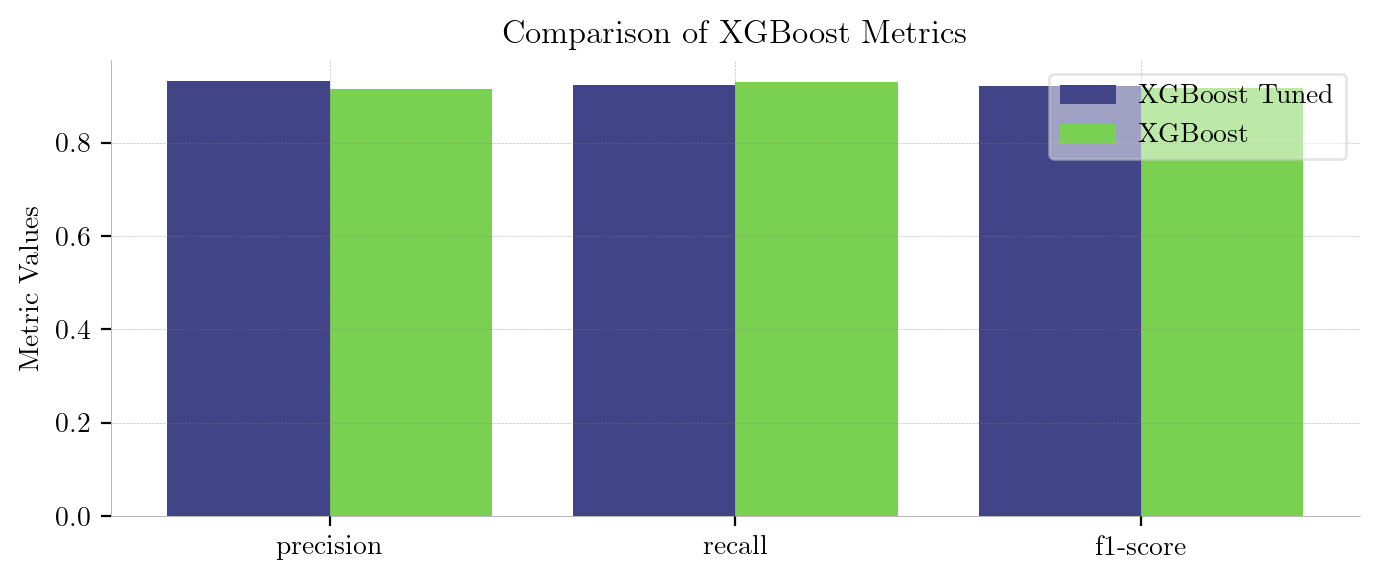

In [103]:
# XGBoosts Comparison
metrics_df = pd.DataFrame({
    "XGBoost_Tuned": xgboost_tuned_metrics[class_labels].mean(axis=1),
    "XGBoost": xgboost_metrics[class_labels].mean(axis=1)
})

# Plotting
fig, ax = plt.subplots(figsize=(7, 3))

# Define x positions and width of bars
x = np.arange(len(metrics_df))  # Indices for the metrics (precision, recall, f1-score)
bar_width = 0.4

# Plot the bars

# Get colors from viridis palette
colors = [viridis(i) for i in np.linspace(0.2, 0.8, 2)]  # Two main bars

# Update the bar plot with viridis colors
ax.bar(x - bar_width / 2, metrics_df["XGBoost_Tuned"], bar_width, label="XGBoost Tuned", color=colors[0])
ax.bar(x + bar_width / 2, metrics_df["XGBoost"], bar_width, label="XGBoost", color=colors[1])

# Add labels, title, and legend
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index.str.replace("XGBClassifier_", ""))  # Simplify metric labels
ax.set_ylabel("Metric Values")
ax.set_title("Comparison of XGBoost Metrics")
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [97]:
xgboost_metrics[class_labels].mean(axis=1)

XGBClassifier_precision    0.915764
XGBClassifier_recall       0.930089
XGBClassifier_f1-score     0.917954
dtype: float64

In [94]:
xgboost_tuned_metrics[class_labels].mean(axis=1)

XGBClassifier_precision    0.931589
XGBClassifier_recall       0.924015
XGBClassifier_f1-score     0.921552
dtype: float64

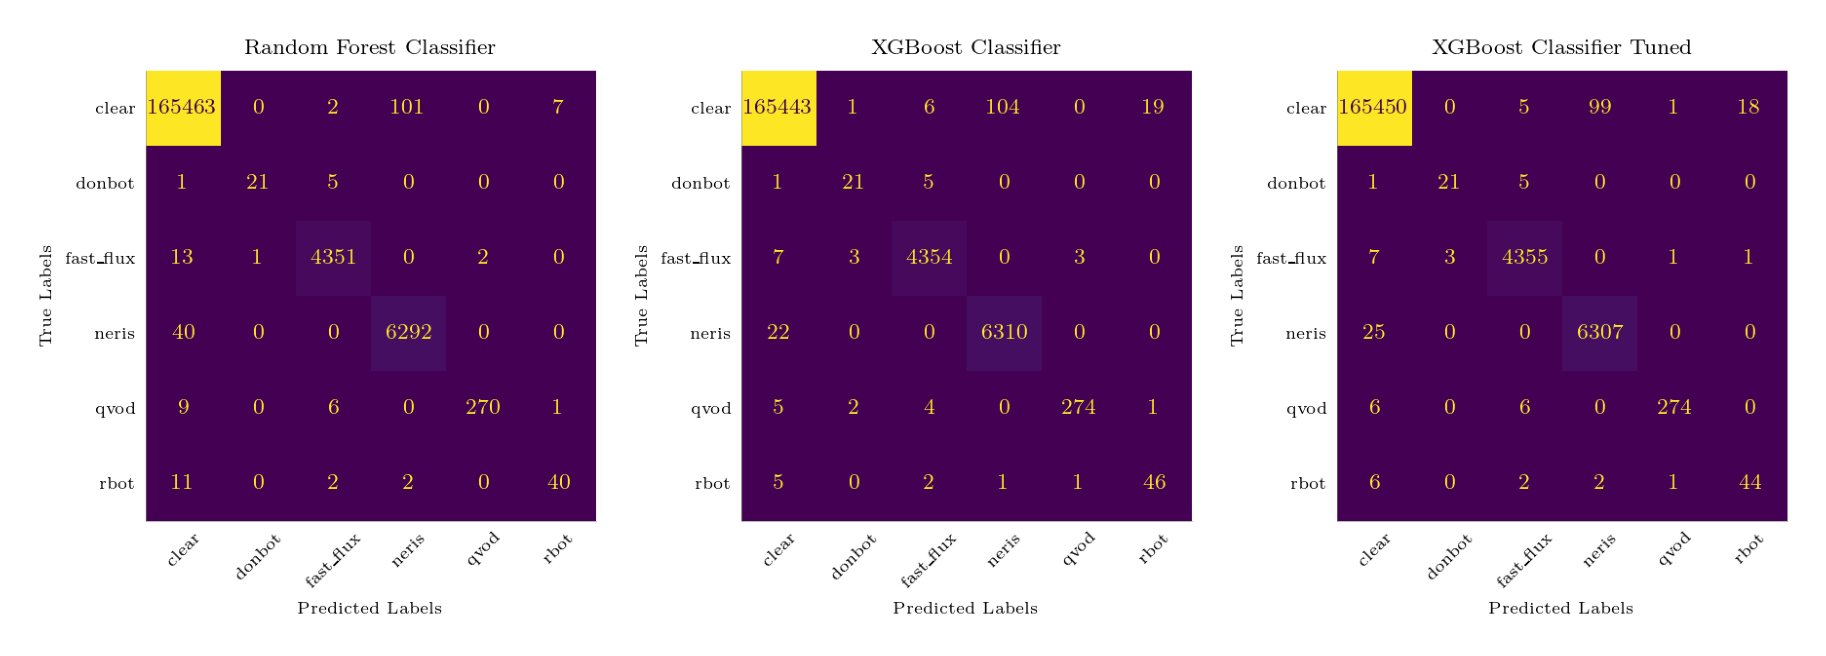

In [91]:
# 📫 Comparison of two best-performing models

# Load the two PNG images
image1 = Image.open("confusion_matrices/random_forest.png")
image2 = Image.open("confusion_matrices/xg_boost.png")
image3 = Image.open("confusion_matrices/xg_boost_tuned.png")

# Ensure both images are the same size
image1 = image1.resize((611, 632))
image2 = image2.resize((611, 632))
image3 = image3.resize((611, 632))

# Combine the images side by side
total_width = image1.width + image2.width + image3.width
total_height = max(image1.height, image2.height, image3.height)
combined_image = Image.new("RGB", (total_width, total_height))

# Paste the images into the combined canvas
combined_image.paste(image1, (0, 0))
combined_image.paste(image2, (image1.width, 0))
combined_image.paste(image3, (image1.width + image2.width, 0))

# Display the combined image
plt.figure(figsize=(16, 4))  # Adjust figure size as needed
plt.imshow(combined_image)
plt.axis("off")  # Turn off the axis
plt.show()